## Clustering evaluation

In [1]:
from datetime import datetime
import pandas as pd

from config import BASE_DIR

RERUN = True

In [2]:


clustering_label = "composition"
CHUNK_SIZE = 100
DATA_PATH = f"{BASE_DIR}/notebooks/data/filtered_text_and_starr_features_{CHUNK_SIZE}_words_nonbib_17_06_2024.csv"
df = pd.read_csv(DATA_PATH)


Our dataset contains chunks of 100 words (using scrolls that have more than 300 words and written in hebrew).
I will use 4 different vectorizers: Starr, trigrams, BERT, tf-idf. When our metric for clustering will be the dgapusta score.

## Hirerchial clustering 

In [3]:
from notebooks.constants import BERT_MODELS
from notebooks.notebooks_utils import set_seed_globaly

set_seed_globaly()

PATH = f"{BASE_DIR}/notebooks/data/test"
FRAC = 1
CONTEXT_SIMILIARITY_WINDOW = 3
linkage_criterion = "ward"
vectorizer_type="tfidf"

In [4]:


from notebooks.clustering import get_dendrogram_feature_order, get_metrics_from_LCA
from notebooks.clustering_main import stratified_sample
from sklearn import cluster as sk
from notebooks.features import create_adjacency_matrix, vectorize_text, get_linkage_matrix
from scipy import sparse as sp
from sknetwork.hierarchy import dasgupta_score as calculate_dasgupta_score


def run_single_clustering(df, frac, context_similiarity_window, vectorizer_type, linkage_criterion):
    sampled_df = stratified_sample(df, 'book', frac=frac, random_state=42)
    print(f"{datetime.now()} - {sampled_df.shape=}")
    adjacency_matrix = create_adjacency_matrix(sampled_df, context_similiarity_window=context_similiarity_window,
                                               composition_level=True)

    vectorizer_matrix = vectorize_text(sampled_df, "text", vectorizer_type)
    print(f"{datetime.now()} - {vectorizer_type=},{vectorizer_matrix.shape=}")
    if sp.issparse(vectorizer_matrix):
        vectorizer_matrix = vectorizer_matrix.toarray()
    model = sk.AgglomerativeClustering(
        distance_threshold=0, n_clusters=None, linkage=linkage_criterion
    )
    model.fit_predict(vectorizer_matrix)
    linkage_matrix = get_linkage_matrix(model)

    dasgupta_score = calculate_dasgupta_score(adjacency_matrix, linkage_matrix)

    print(f"{dasgupta_score=}\n")

    feature_order = get_dendrogram_feature_order(linkage_matrix, df["sentence_path"].to_list())
    _, LCA_metric_mean, LCA_metric_std = get_metrics_from_LCA(feature_order)
    res = {'linkage_matrix': linkage_matrix,
           'sampled_df': sampled_df,
           'vectorizer_matrix': vectorizer_matrix,
           'adjacency_matrix': adjacency_matrix,
           'feature_order': feature_order,
           'model': model,
           'dasgupta_score': dasgupta_score,
           'LCA_metric_mean': LCA_metric_mean
           }
    return res


res = run_single_clustering(df, frac=FRAC, context_similiarity_window=CONTEXT_SIMILIARITY_WINDOW, vectorizer_type=vectorizer_type, linkage_criterion=linkage_criterion)
linkage_matrix, sampled_df, vectorizer_matrix, adjacency_matrix, feature_order, model, dasgupta_score, LCA_metric_mean = [
    res[key] for key in
    ['linkage_matrix', 'sampled_df', 'vectorizer_matrix', 'adjacency_matrix', 'feature_order', 'model',
     'dasgupta_score', 'LCA_metric_mean']]


2024-06-19 12:34:32.633095 - sampled_df.shape=(1365, 26)


Building adjacency matrix:   0%|          | 0/1365 [00:00<?, ?it/s]

2024-06-19 12:34:34.426339 - vectorizer_type='tfidf',vectorizer_matrix.shape=(1365, 18420)
dasgupta_score=0.6700141787419251



### Treemap

Classic dendograms will a lot of data is pretty hard to analyze.
The use of tree-maps can make the evaluation much easier.

Here is an example of how dendogram will look as a treemap:


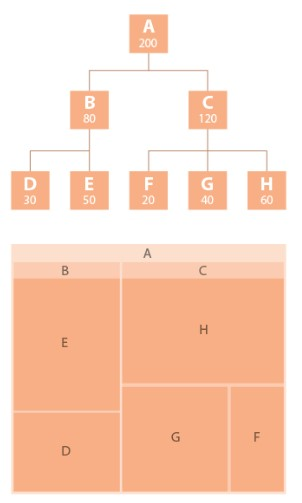

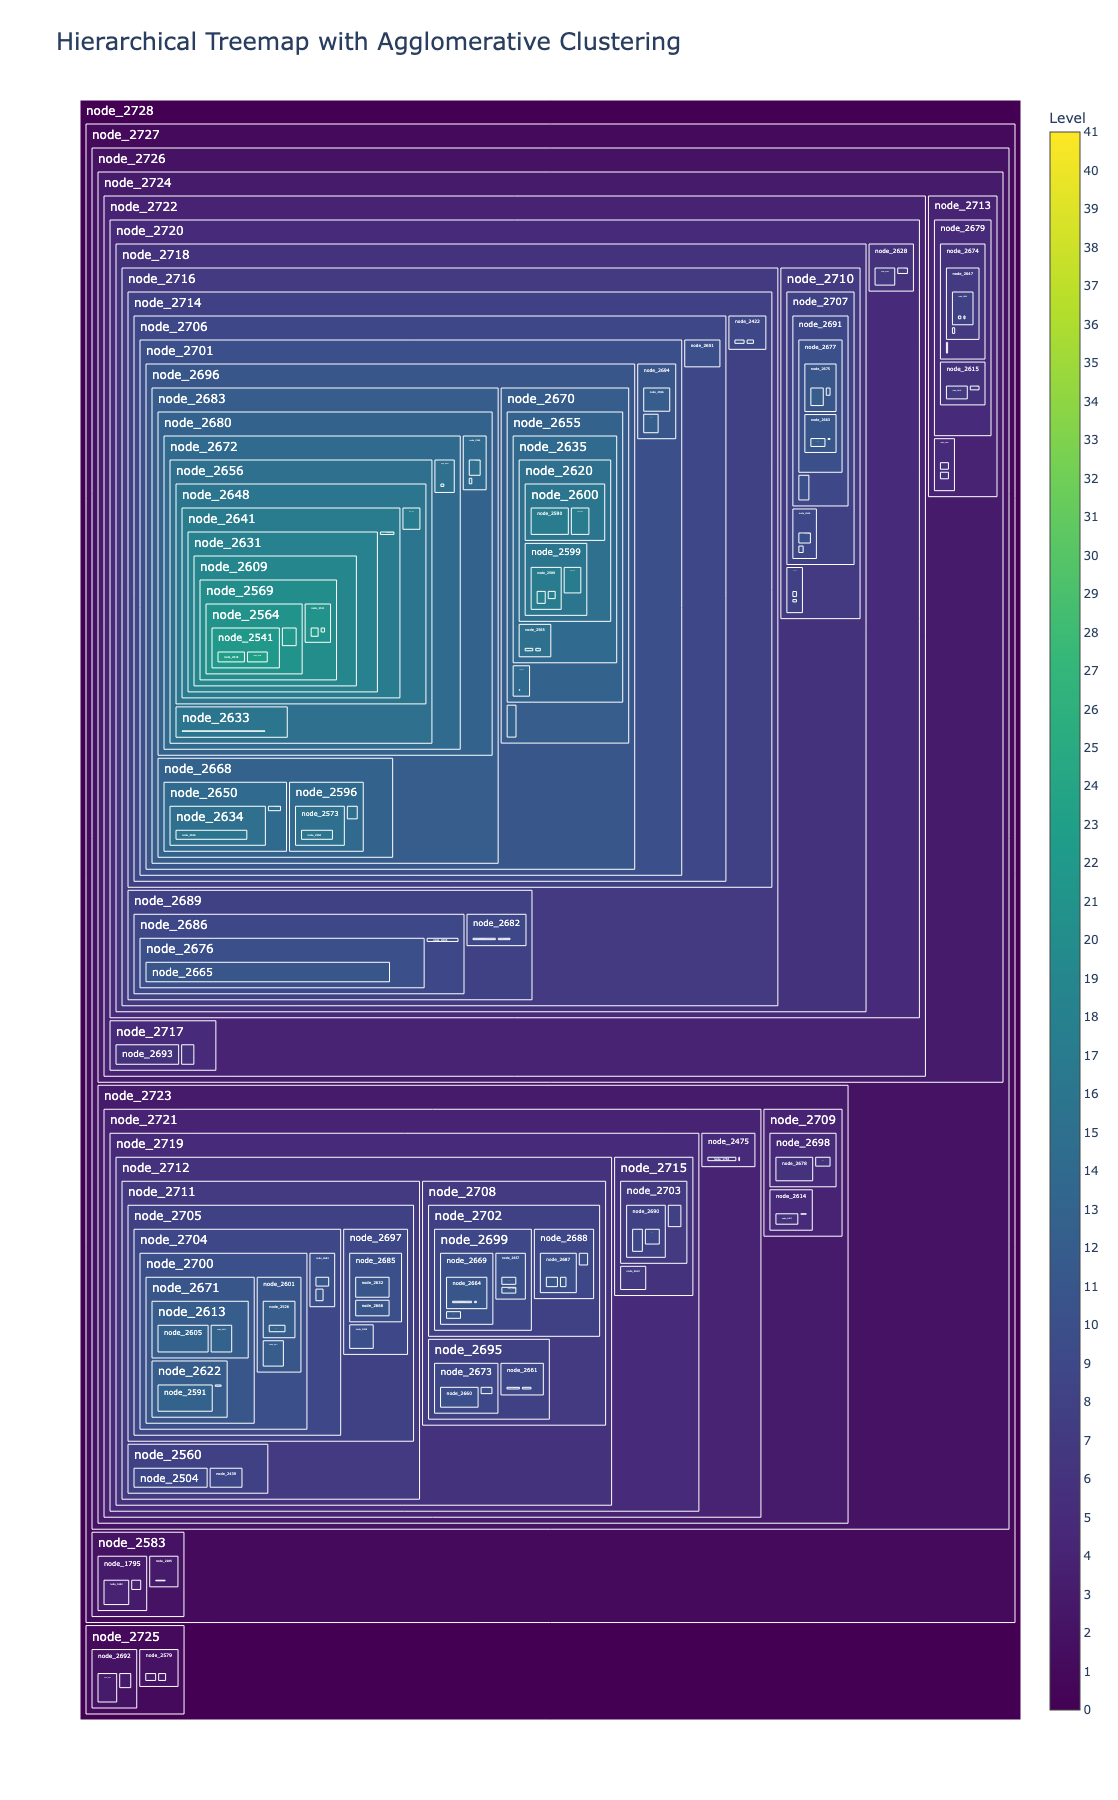

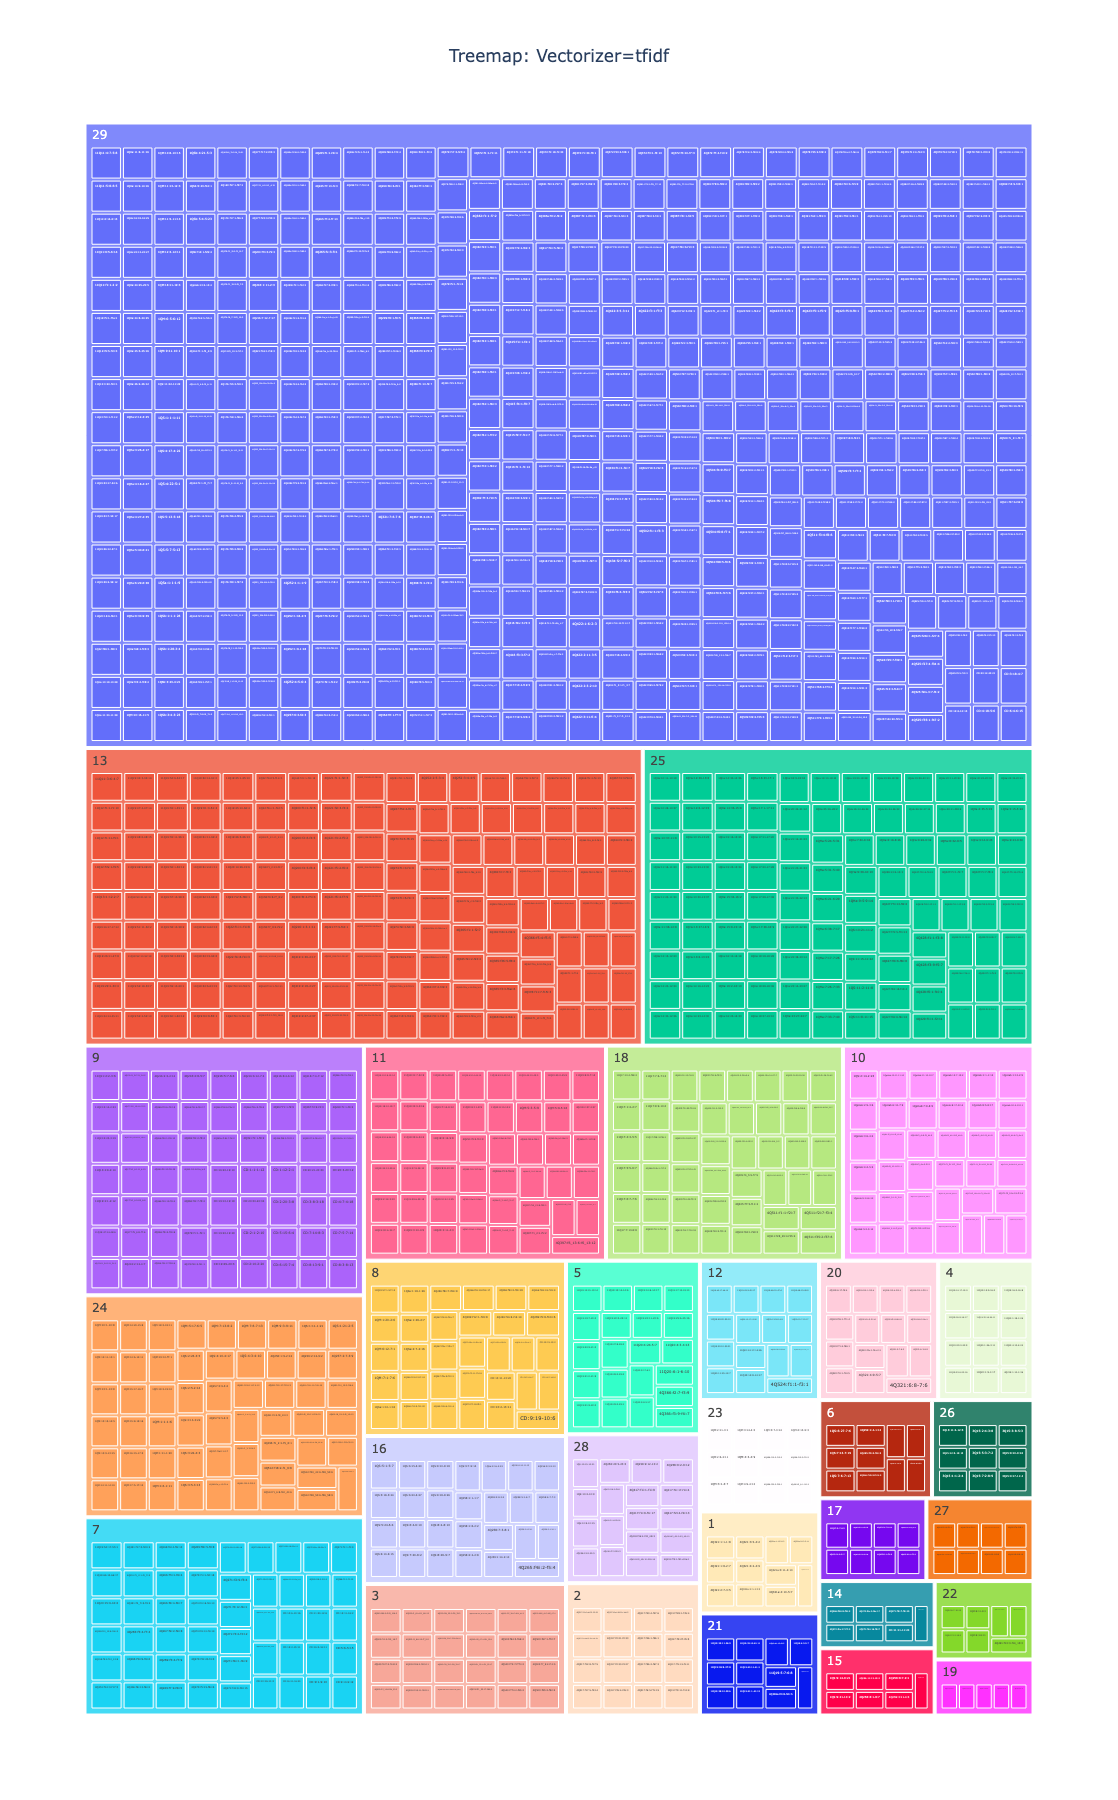

In [5]:

from notebooks.features import shorten_path
from anytree.importer import DictImporter
import ipywidgets as widgets
import pandas as pd
import plotly
#taken from https://towardsdatascience.com/make-a-treemap-in-python-426cee6ee9b8

# Create a recursive function to build the hierarchical structure
def build_tree(node, children, names):
    if node < len(names):
        return {"name": names[node], "value": 1}
    else:
        node_children = children[node - len(names)]
        return {
            "name": f"node_{node}",
            "children": [build_tree(child, children, names) for child in node_children]
        }


# Extract children from the model
n_samples = len(model.labels_)
children = model.children_

# Use the real labels from df["sentence_path"]
names = sampled_df["sentence_path"].apply(shorten_path).tolist()

# Build the hierarchical tree starting from the root node
root_node = n_samples + len(children) - 1
tree = build_tree(root_node, children, names)
tree

importer = DictImporter()
root = importer.import_(tree)

size = []
name = []
parent = []
level = []


def format(node):
    for i in node.children:
        #check if node as attribute value
        if hasattr(i, 'value') == False:
            format(i)
        v = i.value
        #check if node parent as attribute value
        if hasattr(i.parent, 'value'):
            i.parent.value += v
        #if node parent doesn't have a value set to same val as child
        elif hasattr(i.parent, 'value') == False:
            i.parent.value = v

        level.append(len(i.ancestors))
        name.append(i.name)
        parent.append(i.parent.name)
        size.append(i.value)


format(root)

#append attributes for root
level.append(0)
name.append(root.name)
parent.append("")
size.append(root.value)

#create df
df_plotly = pd.DataFrame()
df_plotly['parent'] = parent
df_plotly['name'] = name
df_plotly['value'] = size
df_plotly['level'] = level


import plotly.graph_objects as go
# LOWEST_LEVEL_COLORED = int(df_plotly['level'].quantile(0.8))
LOWEST_LEVEL_COLORED = int(df_plotly['level'].max())
colors = []
for level in df_plotly['level']:
    if level > LOWEST_LEVEL_COLORED:
        colors.append('#cccccc')  # Color for levels below 30
    else:
        colors.append(level)  # Use level value for coloring above 30

# Function to create and save the treemap plot
def create_treemap():
    fig = go.Figure()
    fig.add_trace(go.Treemap(
        labels=df_plotly['name'],
        values=df_plotly['value'],
        parents=df_plotly['parent'],
        marker=dict(
            colors=colors,
            colorscale='Viridis',  # Change to any Plotly colorscale or define your own
            colorbar=dict(
                title="Level",
                 tickvals=[i for i in range(0, LOWEST_LEVEL_COLORED+1)],
                ticktext=[str(i) for i in range(0, LOWEST_LEVEL_COLORED+1)]
            )
        )
    ))
    fig.update_traces(root_color="#f1f1f1")
    fig.update_layout(
        width=1150, 
        height=1800, 
        title="Hierarchical Treemap with Agglomerative Clustering",
        title_font_size=24,
        colorway=['#636efa', '#EF553B', '#00cc96', '#ab63fa', '#19d3f3', '#e763fa', '#fecb52', '#FFA15A', '#ff6692', '#b6e880']
    )
    return fig

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import fcluster
import plotly.express as px


def create_treemap_not_hirerchial():
    color_threshold = 0.5
    max_d = color_threshold * max(linkage_matrix[:, 2])
    clusters = fcluster(linkage_matrix, max_d, criterion='distance')
    
    # Create a DataFrame for Plotly
    df__ = pd.DataFrame({
        'sample_name': sampled_df["sentence_path"].tolist(),
        'cluster': clusters
    })
    
    
    # Create a treemap
    fig = px.treemap(df__, path=['cluster', 'sample_name'], values=np.ones(len(df__)),
                     title=f'Treemap: Vectorizer={vectorizer_type}, All Data')
    fig.update_layout(
       width=1150, 
        height=1800, 
        title={
            'text': f'Treemap: Vectorizer={vectorizer_type}',
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        }
    )
    return fig

fig1 = create_treemap()
fig2 = create_treemap_not_hirerchial()
description = f"""<p>Linkage criterin: {linkage_criterion}, Dasgupta score: {dasgupta_score:.3f}, max-dist metric: {LCA_metric_mean:.3f}.</p>
<p>This interactive treemap represents the hierarchical structure generated by agglomerative clustering (vectorizer: {vectorizer_type}).</p>
    <p>Each node represents a cluster, and the size of each node corresponds to the number of samples in that cluster.</p>"""
html_content = '''<html>
<head>
<title>Interactive Treemap</title>
<style>
    body {{font-family: Arial, sans-serif; margin: 40px; background-color: #f4f4f9;}}
    h1 {{color: #333333;}}
    p {{font-size: 16px; color: #555555; line-height: 1.6;}}
    .container {{max-width: 1400px; margin: auto; background: #ffffff; padding: 20px; box-shadow: 0 0 10px rgba(0, 0, 0, 0.1);}}
</style>
</head>
<body>
<div class="container">
    <h1>Hierarchical Treemap Visualization</h1>
    {}
    {}
    {}
    '''
html_content = html_content.format(description, fig1.to_html(full_html=False, include_plotlyjs='cdn'), fig2.to_html(full_html=False, include_plotlyjs='cdn'))
with open(f"{BASE_DIR}/notebooks/reports/interactive_treemap_{vectorizer_type.replace('/','_')}.html", 'w') as f:
    f.write(html_content)
    # f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write('''
</div>
</body>
</html>''')

fig1.show()
fig2.show()
# Create and save the treemap plot


## Dendogram

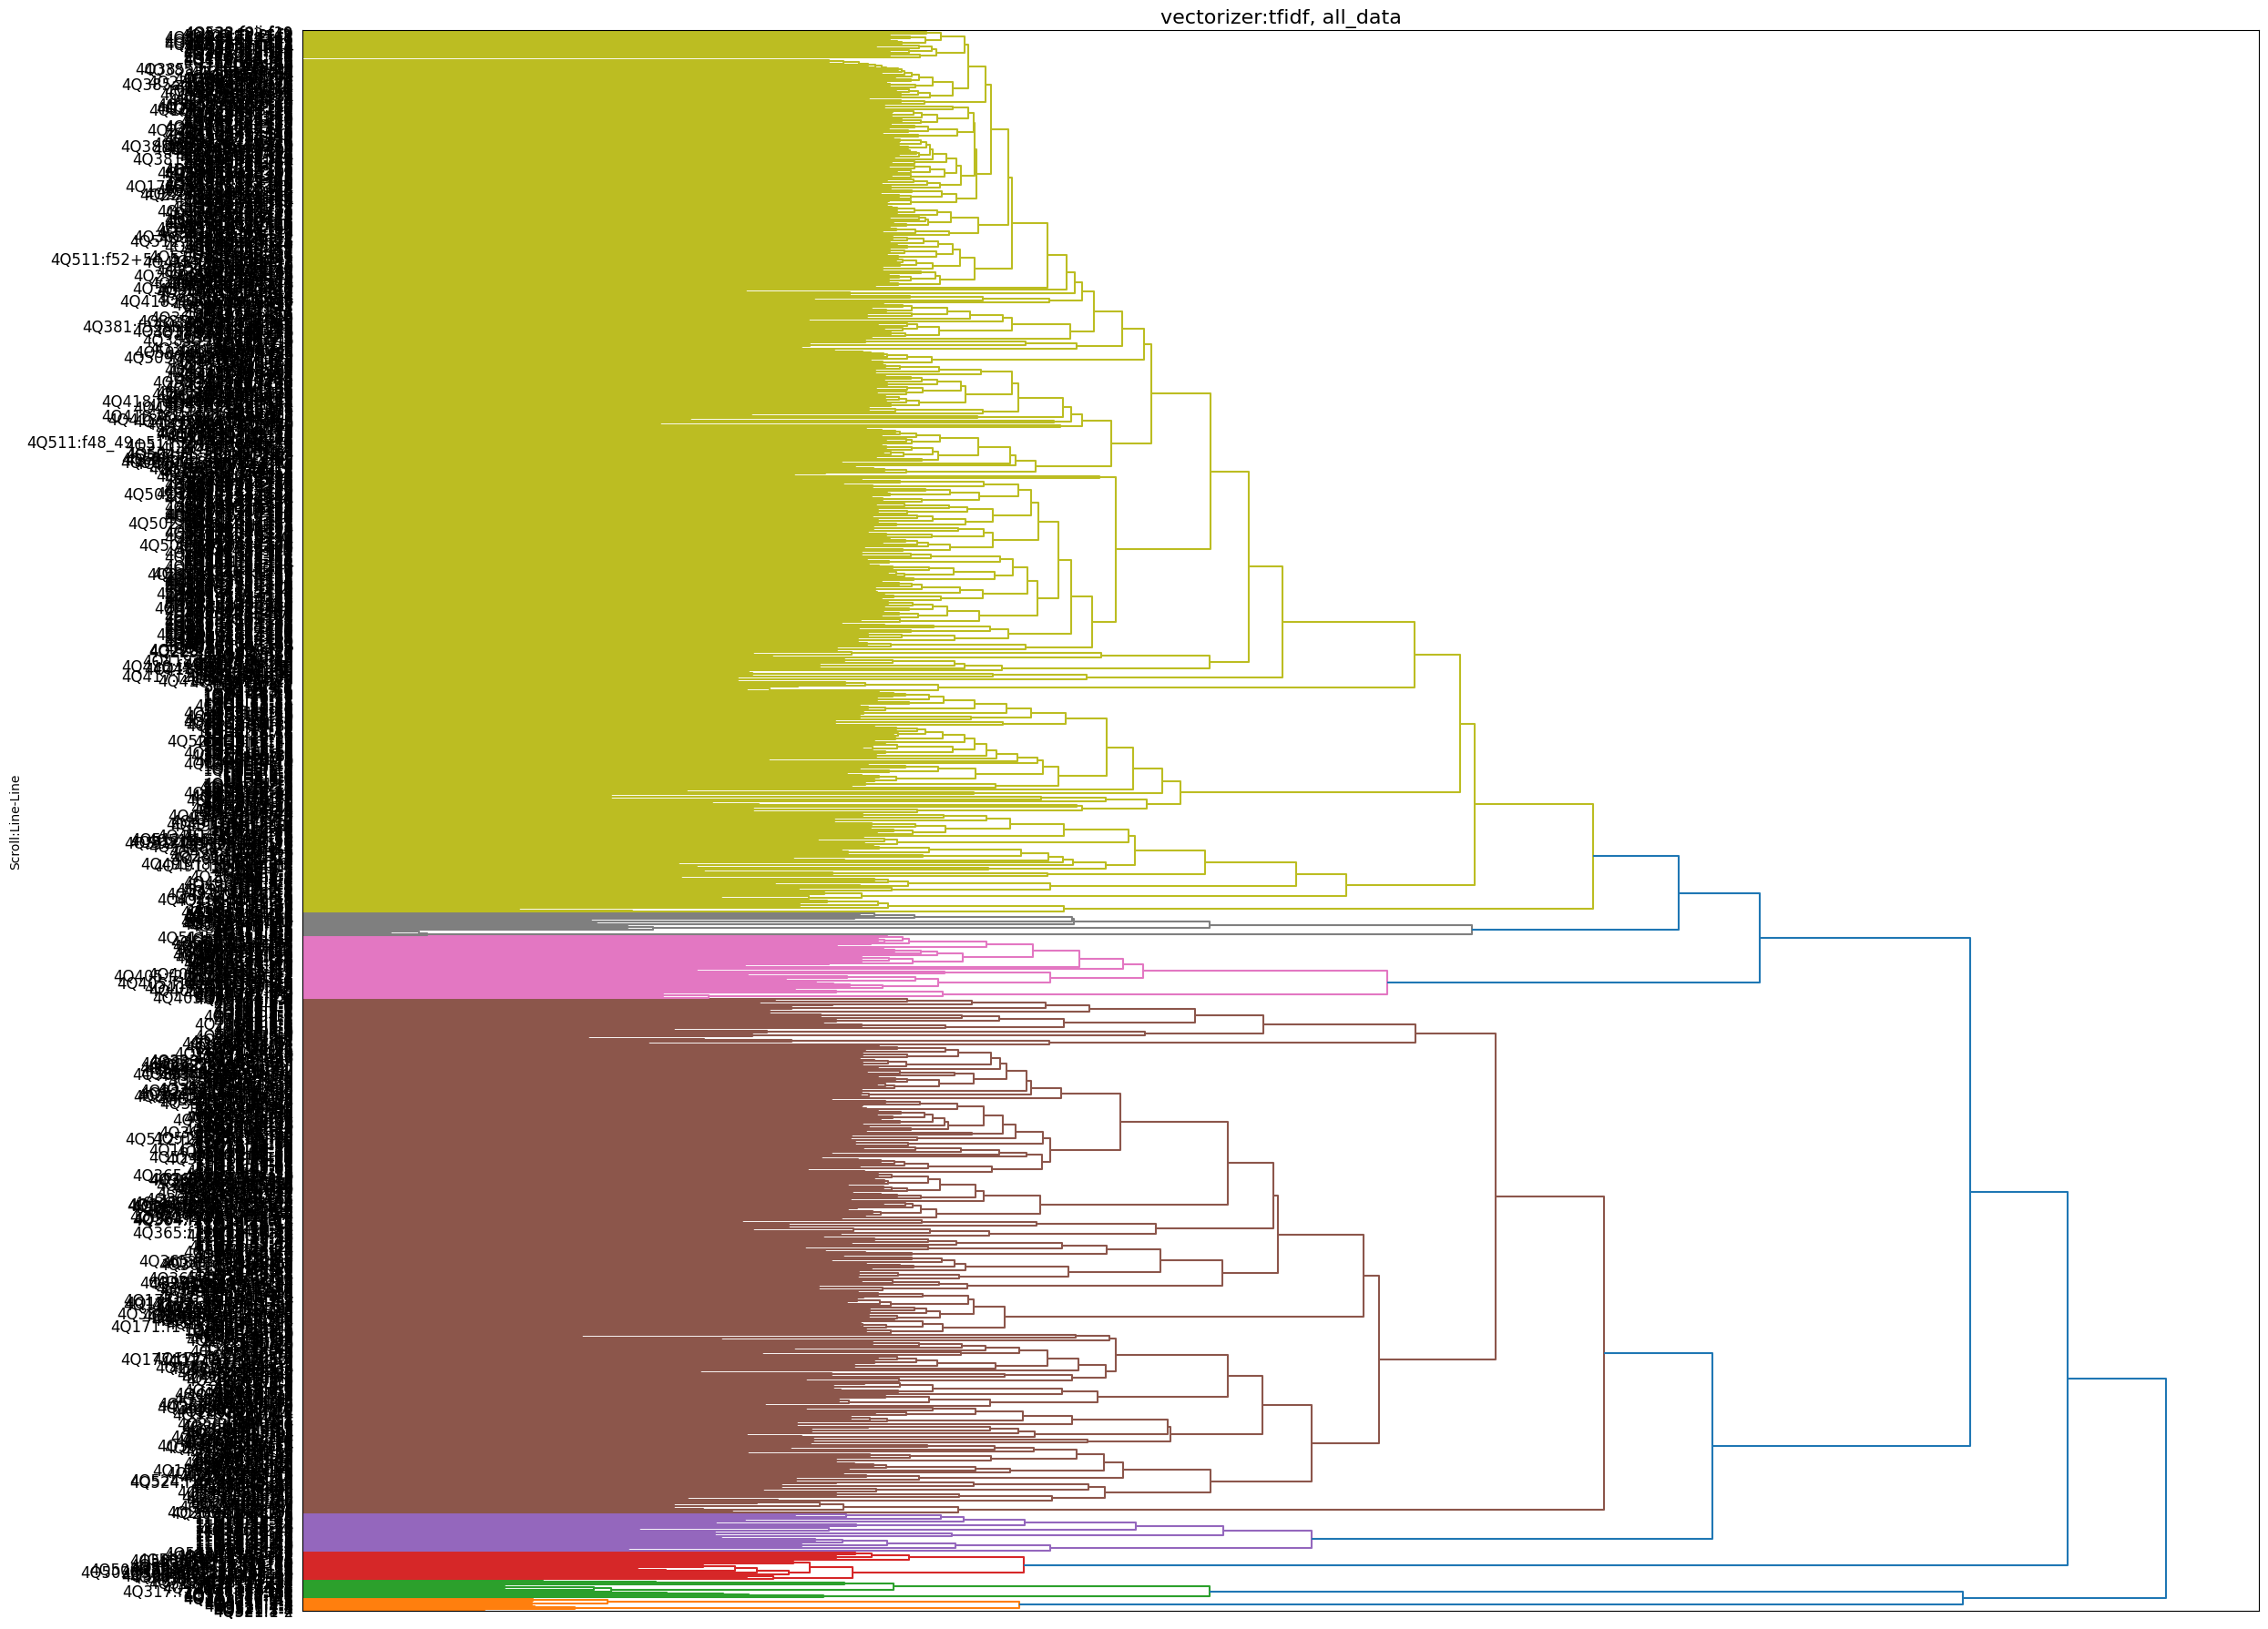

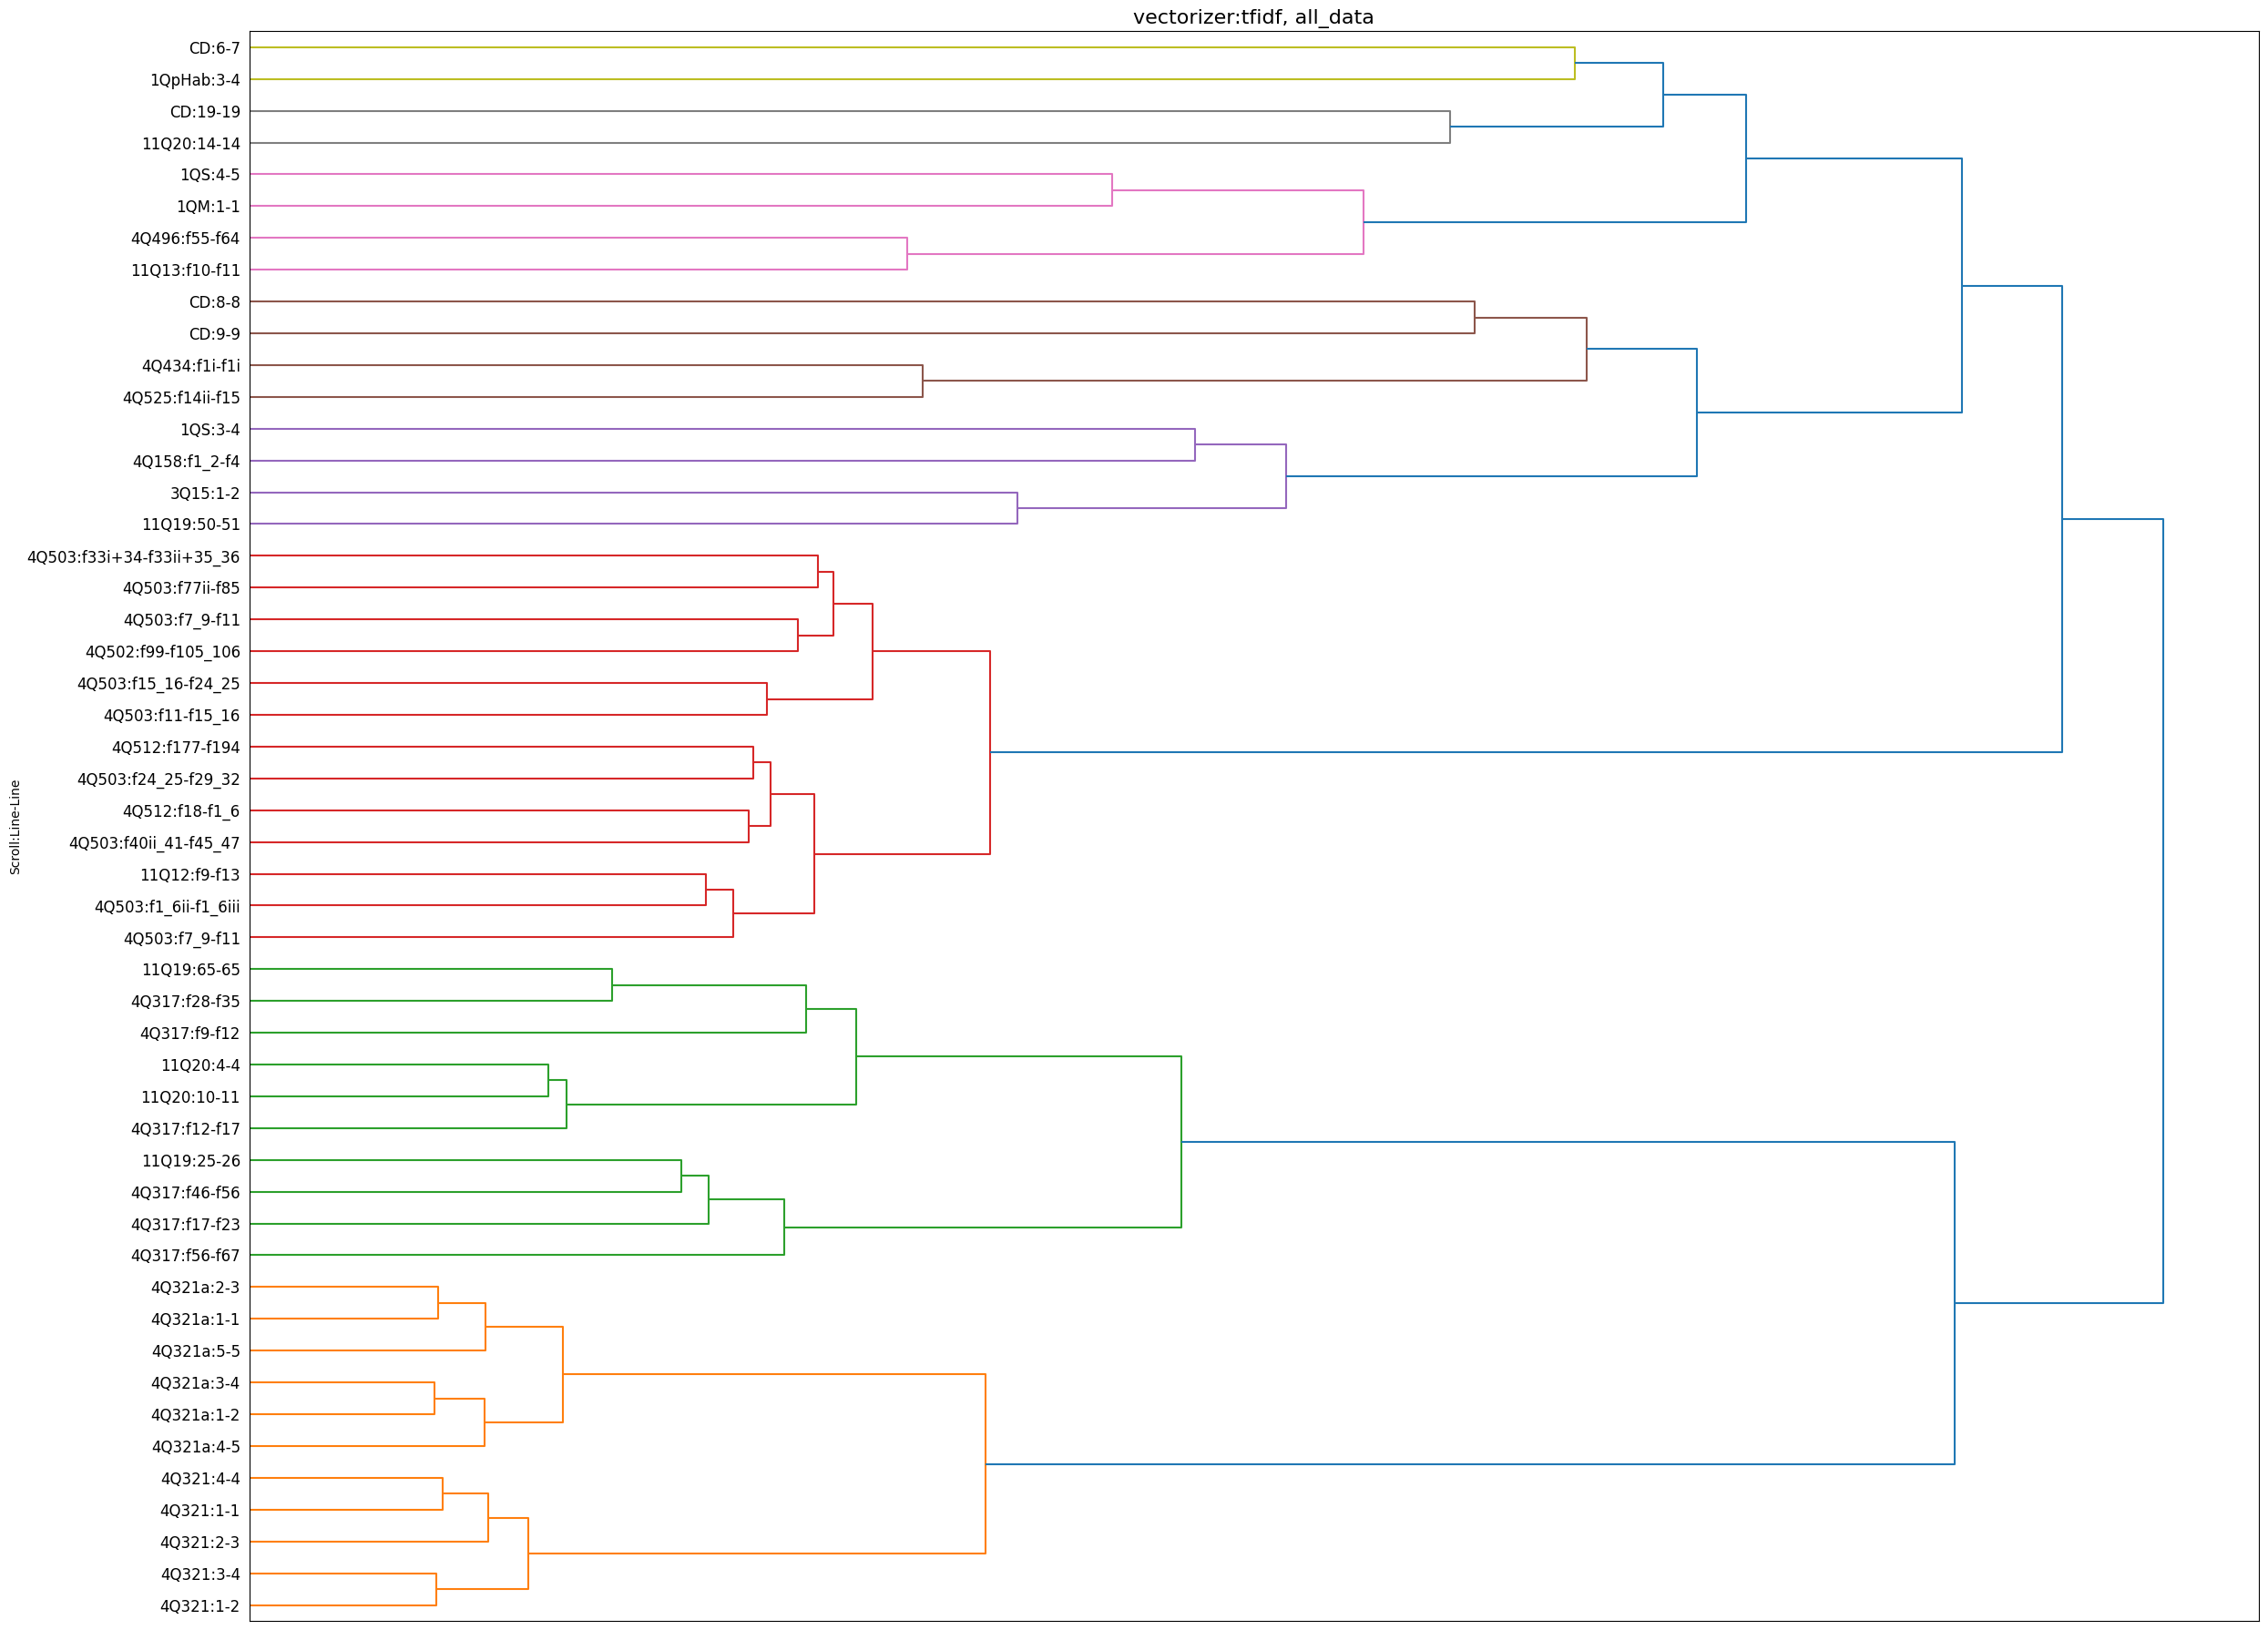

In [6]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
path_to_image = f"{BASE_DIR}/notebooks/data/test"


def llf(id):
    if id < len(sample_names):
        return sample_names[id]
    else:
        return f'{sample_names[len(sample_names) - id]}'


def matplotlib_dendrogram(linkage_matrix, sample_names, title, save=False, level=None, metadata=None):
    plt.figure(figsize=(25, 18))

    dendrogram(
        linkage_matrix,
        leaf_label_func=llf,
        orientation="right",

        color_threshold=0.7 * max(linkage_matrix[:, 2]),  # Adjust color threshold,
        truncate_mode="level" if level else level,
        p=30 if not level else level
    )

    plt.title(f'vectorizer:{metadata["vectorizer_type"]}, all_data', fontsize=16)
    plt.ylabel("Scroll:Line-Line")
    plt.tick_params(
        axis="x",  # changes apply to the x-axis
        which="both",  # both major and minor ticks are affected
        bottom=False,  # ticks along the bottom edge are off
        top=False,  # ticks along the top edge are off
        labelbottom=False,
    )
    plt.tick_params(
        axis="y",  # changes apply to the x-axis
        which="both",  # both major and minor ticks are affected,
        labelsize=12,
    )
    plt.tight_layout()
    if save:
        full_image_path = (f"{path_to_image}/{title}{metadata['vectorizer_type']}_{title}.png")
        print(f"saved: {path_to_image}/_{title}{metadata['vectorizer_type']}.png")
        plt.savefig(full_image_path)
    plt.show()


sample_names = sampled_df["sentence_path"].apply(shorten_path).to_list()
matplotlib_dendrogram(linkage_matrix, sample_names, level=None, title="full_dendogram",
                      metadata={"vectorizer_type": vectorizer_type})
matplotlib_dendrogram(linkage_matrix, sample_names, level=5, title="dendogram_level_5",
                      metadata={"vectorizer_type": vectorizer_type})

### TSNE


FloatSlider(value=0.2, description='TSNE_FRAC:', max=0.5, min=0.1)

Output()

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/threadpoolctl.py:1010: RuntimeWarning:


Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md


/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_20410/555891093.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/sklearn

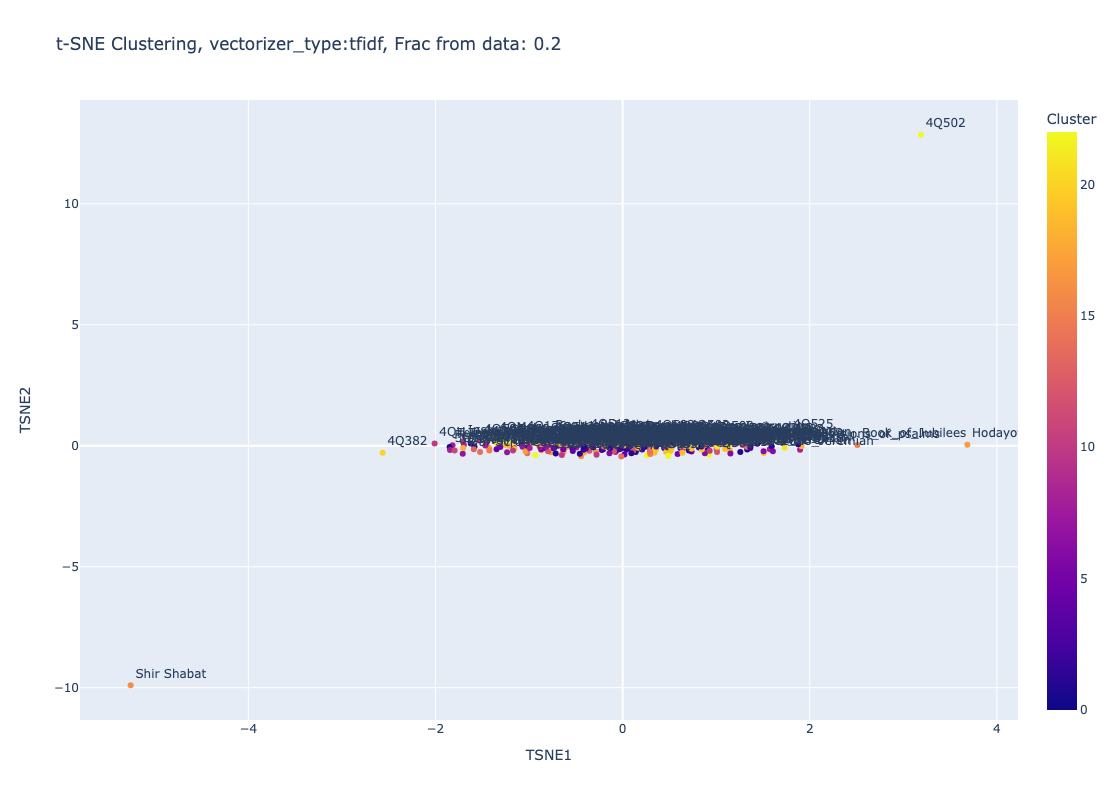

In [7]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

def cluster_data(data, num_clusters=5, random_state=42):
    kmeans = KMeans(n_clusters=num_clusters, random_state=random_state)
    clusters = kmeans.fit_predict(data)
    return clusters

def plot_tsne(data, clusters, clustering_labels, hover_label, random_state=42, metadata=None):
    tsne = TSNE(n_components=2, random_state=random_state, perplexity=40)
    if type(data) != np.ndarray:
        data = data.toarray()
    tsne_results = tsne.fit_transform(data)
    tsne_results = StandardScaler().fit_transform(tsne_results)
    tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df['Cluster'] = clusters
    tsne_df['Label'] = clustering_labels
    tsne_df['sentence_path'] = hover_label
    
    fig = px.scatter(tsne_df, x='TSNE1', y='TSNE2', color='Cluster', text='Label',hover_data=['sentence_path'],
                     title=f't-SNE Clustering, vectorizer_type:{metadata.get("vectorizer_type")}, Frac from data: {metadata.get("frac")}',
                     width=1200, height=800)
    fig.update_traces(textposition='top right')
    fig.show()

def update_plot(tsne_frac):
    TSNE_FRAC = tsne_frac
    sampled_indexes = sampled_df.sample(frac=TSNE_FRAC).index
    df_sampled_tsne = sampled_df.iloc[sampled_indexes, :]
    
    vectorizer_matrix_tsne = vectorizer_matrix[sampled_indexes, :]
    clusters = cluster_data(vectorizer_matrix_tsne, df_sampled_tsne["composition"].nunique() + 1)
    df_sampled_tsne['composition'] = df_sampled_tsne['composition'].fillna(df_sampled_tsne['book'])
    plot_tsne(vectorizer_matrix_tsne, clusters, df_sampled_tsne.reset_index()['composition'].fillna(df_sampled_tsne['book']),
              df_sampled_tsne.reset_index()["sentence_path"],metadata={"vectorizer_type": vectorizer_type, "frac": TSNE_FRAC})

# Assuming sampled_df and vectorizer_matrix are defined
TSNE_FRAC_slider = widgets.FloatSlider(value=0.2, min=0.1, max=0.5, step=0.1, description='TSNE_FRAC:')
output = widgets.Output()

def on_value_change(change):
    with output:
        output.clear_output(wait=True)
        update_plot(change.new)

TSNE_FRAC_slider.observe(on_value_change, names='value')

display(TSNE_FRAC_slider, output)

# Initial plot
update_plot(TSNE_FRAC_slider.value)


### Supervised

In [12]:
vectorizers = ["trigram",
               "tfidf",
               "bert", "starr"
               ]

In [13]:
from sklearn.metrics import adjusted_rand_score

FRAC = 1

clustering_label = 'composition'
df_sampled = stratified_sample(df, 'book', frac=FRAC, random_state=42)
df_sampled = df_sampled.dropna(subset=[clustering_label])
for vectorizer_type in vectorizers:
    X = vectorize_text(df_sampled, "text", vectorizer_type)

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(df_sampled[clustering_label])

    X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.3, random_state=42)

    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    # Compute Jaccard Index
    jaccard_index = jaccard_score(y_test, y_pred, average='macro')
    rand_index = adjusted_rand_score(y_test, y_pred)
    print(f"{vectorizer_type}, Jaccard Index: {jaccard_index}")

    unique_classes = sorted(set(y_test))
    target_names = [label_encoder.inverse_transform([cls])[0] for cls in unique_classes]

# Print classification report
# print(classification_report(y_test, y_pred, labels=unique_classes, target_names=target_names))



trigram, Jaccard Index: 0.24122398430790457
tfidf, Jaccard Index: 0.25034451783934186


/Users/yonatanlou/.pyenv/versions/3.10.0/envs/QumranNLP/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


bert:   0%|          | 0/812 [00:00<?, ?it/s]

bert, Jaccard Index: 0.27841723891960474
starr, Jaccard Index: 0.21583140999824635


### 
Silhouette Score
The Silhouette Score measures how similar an object is to its own cluster compared to other clusters. The formula for the Silhouette Score for a single sample is:
$$ s = \frac{b - a}{\max(a, b)} $$
where $a$ is the mean distance to the other samples in the same cluster (cohesion), and $b$ is the mean distance to the samples in the nearest cluster (separation). A higher Silhouette Score is better, with a maximum of 1 indicating perfect clustering.

### Davies-Bouldin Index
The Davies-Bouldin Index evaluates the average similarity between each cluster and its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. The formula is:
$$ DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left( \frac{\sigma_i + \sigma_j}{d(c_i, c_j)} \right) $$
where $\sigma$ is the average distance of all points in the cluster to the cluster centroid $c$, and $d(c_i, c_j)$ is the distance between centroids $c_i$ and $c_j$. A lower Davies-Bouldin Index indicates better clustering.

### Adjusted Rand Index
The Adjusted Rand Index is a measure of the similarity between two data clusterings, corrected for chance. It has a maximum of 1 and can be less than 0. The formula for the Adjusted Rand Index is:
$$ ARI = \frac{\sum_{ij} \binom{n_{ij}}{2} - [\sum_i \binom{a_i}{2} \sum_j \binom{b_j}{2}] / \binom{n}{2}}{\frac{1}{2} [\sum_i \binom{a_i}{2} + \sum_j \binom{b_j}{2}] - [\sum_i \binom{a_i}{2} \sum_j \binom{b_j}{2}] / \binom{n}{2}} $$
where $n_{ij}$ is the number of objects in both clusters $i$ and $j$, $a_i$ is the number of objects in cluster $i$, and $b_j$ is the number of objects in cluster $j$. Higher values are better.

### Mutual Information
Mutual Information measures the amount of information shared between two clusterings, reflecting how much knowing one of these clusterings reduces uncertainty about the other. The formula is:
$$ MI = \sum_{k,l} P(k,l) \log \frac{P(k,l)}{P(k)P(l)} $$
where $P(k,l)$ is the joint probability distribution function of clusterings $k$ and $l$, and $P(k)$ and $P(l)$ are the marginal probability distributions. Higher values indicate more shared information.

### Jaccard Index
The Jaccard Index, or Jaccard similarity coefficient, measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:
$$ J(A,B) = \frac{|A \cap B|}{|A \cup B|} $$
where $A$ and $B$ are sets of labels. Higher values are better, indicating a greater overlap between the clusters compared to the total size.


In [15]:
DATA_PATH = f"{BASE_DIR}/notebooks/data/filtered_text_and_starr_features_{CHUNK_SIZE}_words_nonbib_17_06_2024.csv"
df = pd.read_csv(DATA_PATH)
DATA_PATH = f"{BASE_DIR}/notebooks/data/text_and_starr_features_{CHUNK_SIZE}_words_nonbib_17_06_2024.csv"
df_all = pd.read_csv(DATA_PATH)
df_all

book                      sentence_path  \
0                CD                        CD:1:1-1:12   
1                CD                        CD:1:12-2:1   
2                CD                        CD:2:1-2:10   
3                CD                       CD:2:10-2:20   
4                CD                        CD:2:20-3:8   
...             ...                                ...   
4445  Arugleviticus  Arugleviticus:fB+Cii:14-fB+Cii:16   
4446        Xjoshua                    Xjoshua:1:1-2:9   
4447        Xjudges               Xjudges:f1:1-f3_7i:5   
4448        Xjudges           Xjudges:f3_7i:5-f3_7ii:1   
4449             X4                       X4:f1:1-f2:3   

                                               text_lex  \
0     שמע כל ידע צדק בין מעשה אל ריב ל כל בשר משפט ע...   
1     אחרון עשה דור אחרון עדה בגד הם סור דרך היא עת ...   
2     כל המון מעשה נדה פנה שמע אל כל בוא ברית גלה אז...   
3     כל שנה עולם כל קום ל קריא שם יתר פליטה ארץ מלא...   
4     בשר היה חרבה גוע היה היה עשה רצון שמר מצוה עשה...   
...                                                 ...   
4445                  מות נכה נפש בהמה שלם נפש תחת נפש    
4446  צוה חזק אמץ ערץ חתת עם יהוה אלהים כל הלך צוה י...   
4447  הלך יהודה כנעני ישב חברון שם חברון פנה קרית אר...   
4448  משך הר תבור לקח עם עשרה אלף איש בן נפתלי בן זב...   
4449                               הלך ל מלקוש עבל אלה    

                                                   text  n_words_lex  n_words  \
0     ועתה שמעו כל יודעי צדק ובינו במעשי אל כי ריב ל...           82       92   
1     אחרונים את אשר עשה בדור אחרון בעדת בוגדים הם ס...           85       96   
2     את כל המונם ומעשיהם לנדה לפניו ועתה שמעו אלי כ...           79       94   
3     לכל שני עולם ובכולם הקים לו קריאי שם למען התיר...           79       94   
4     בשר אשר היה בחרבה כי גוע ויהיו כלא היו בעשותם ...           81       95   
...                                                 ...          ...      ...   
4445             יומת ומכה נפש בהמה ישלמנה נפש תחת נפש             9        9   
4446  הלוא צויתיך חזק ואמץ אל תערץ ואל תחת כי עמך יה...           62       78   
4447  וילך יהודה אל הכנעני הישב בחברון ושם חברון לפנ...           80       93   
4448  ומשכת בהר תבור ולקחת עמך עשרת אלפים איש מבני נ...           42       54   
4449                            לא אלך ל מלקוש עבל אלה             6        8   

      construct to absolute nouns ratio  \
0                              0.666667   
1                              0.545455   
2                              0.481481   
3                              1.250000   
4                              1.100000   
...                                 ...   
4445                           0.500000   
4446                           1.333333   
4447                          -1.000000   
4448                           6.000000   
4449                          -1.000000   

      construct nouns and adjectives percentage  noun to verb ratio  \
0                                      0.110092            2.250000   
1                                      0.114286            1.241379   
2                                      0.130841            2.222222   
3                                      0.205607            1.714286   
4                                      0.103774            1.000000   
...                                         ...                 ...   
4445                                   0.083333            2.500000   
4446                                   0.044944            1.045455   
4447                                   0.074074            1.791667   
4448                                   0.093750            1.333333   
4449                                   0.000000            1.000000   

      definite_article_percentage  ...  preterite percentage  ky percentage  \
0                        0.917431  ...              6.422018            0.0   
1                        4.761905  ...              9.523810            0.0   
2                        0.93

In [28]:
ss = df_all[df_all["bib"] == "nonbib"].groupby("book")["total word count"].sum().to_frame()
ss["more_than_300_word"] = ss["total word count"] > 300
ss.sort_values(by="total word count").to_csv(f"{BASE_DIR}/notebooks/data/scrolls_by_word_count.csv")